In [69]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.optimize import brentq

Опираясь на [карту](https://eusipa.org/wp-content/uploads/European_map_20160530_2016.pdf) Европейской ассоциации структурных инвестиционных
продуктов (EUSIPA) и ее [российскую адаптацию](https://naufor.ru/tree.asp?n=22890)

привести 2-3 ссылки на

*   структурные продукты, представленные на россиском рынке,
*   доступные наборы данных (напрмер, [HKEX](https://www.hkex.com.hk/Products/Securities/Structured-Products/Trading-Information-and-Historical-Data?sc_lang=en)).

Московская Биржа (MOEX): 


# Cтруктурный продукт с полной защитой капитала

## СП с использованием бинарных опционов

Пример. Имеется 0,1 млн рублей, которые клиент готов инвестировать на 1 год. Ожидается, что текущая цена акции, равная 100 руб., не изменится более чем на 10%. Волатильность акции – 30%, депозитная процентная ставка и безрисковая процентная
ставка – 7%.

Постройте структурный продукт с полной защитой капитала и использованием опционной стратегии бинарный диапазон (binary range).

In [2]:
# оценка стоимости бинарного опциона колл
def binary_option_call(t, S, K, T, r, q, sigma):

    d1 = (np.log(S/K) + (r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == 'cash-or-nothing':
      return np.exp(-r*T)*norm.cdf(d2)
    if t == 'asset-or-nothing':
      return S*np.exp(-q*T)*norm.cdf(d1)

# оценка стоимости бинарного опциона пут
def binary_option_put(t, S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == 'cash-or-nothing':
      return np.exp(-r*T)*norm.cdf(-d2)
    if t == 'asset-or-nothing':
      return S*np.exp(-q*T)*norm.cdf(-d1)

In [3]:
S = 100
K = 100
T = 1
r = 0.07
q = 0
N = 100000
sigma = 0.3
n = 100

In [4]:
K=90
b90 = binary_option_call('cash-or-nothing', S, K, T, r, q, sigma)
K=110
b110 = binary_option_call('cash-or-nothing', S, K, T, r, q, sigma)
print('digital range = ', b90-b110)

digital range =  0.24307515482345715


In [5]:
risk_part = N - N*np.exp(-r*T)
Q = round(risk_part/(b90-b110))
print('количество опционных стратегий', Q)

количество опционных стратегий 27813


In [6]:
print('максимальная доходность, годовых = ', (N+Q)/(N*T)-1)
print('максимальная доходность, непрерывно = ', np.log((N+Q)/(N*T)))

максимальная доходность, годовых =  0.27813
максимальная доходность, непрерывно =  0.24539807222181784


In [8]:
def call(S, K, T, sigma, r, q):
    d1 = (np.log (S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp (-r * T) * norm.cdf(d2)

Пример. Постройте график доходности структурного продукта в сравнении с доходностью базового актива и безрисковой ставки.

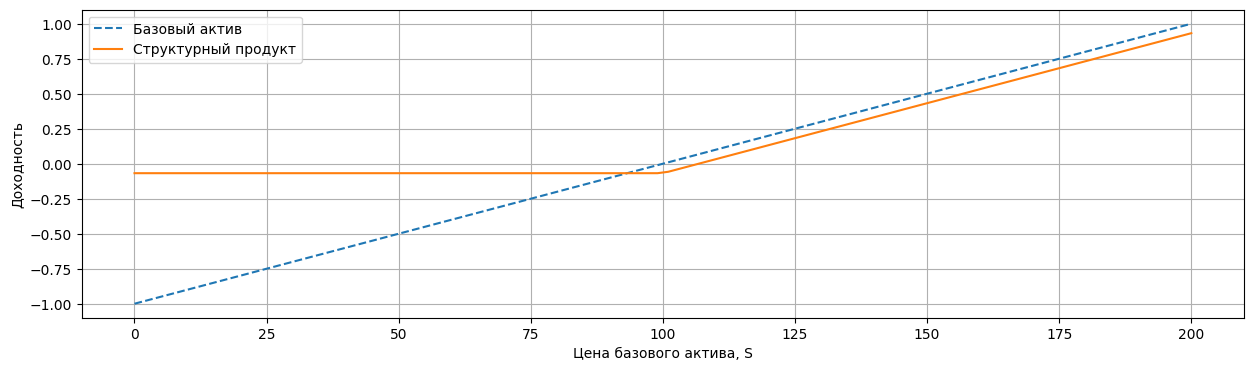

In [9]:
risk_part = N - N * np.exp(-r * T)
c = call(S, K, T, sigma, r, q)
PR = S * round(risk_part / c) / N

underlying_asset_profit = np.linspace(- S, S, n) / S
struct_product_profit = np.maximum(0, underlying_asset_profit) - round(risk_part / c) * c / N

x = np.linspace(0, 2 * S, n)
plt.figure(figsize=(15, 4))
#plt.title('Profit UA vs OC')
plt.plot(x, underlying_asset_profit, '--', label='Базовый актив')
plt.plot(x, struct_product_profit,  label='Структурный продукт')
plt.ylabel('Доходность')
plt.xlabel('Цена базового актива, S')
plt.grid()
plt.legend()
plt.show()

Пример. Постройте график зависимости коэффициента участия от встроенной комиссии, проварьируйте комиссию от 0 до 10% с шагом 1%.

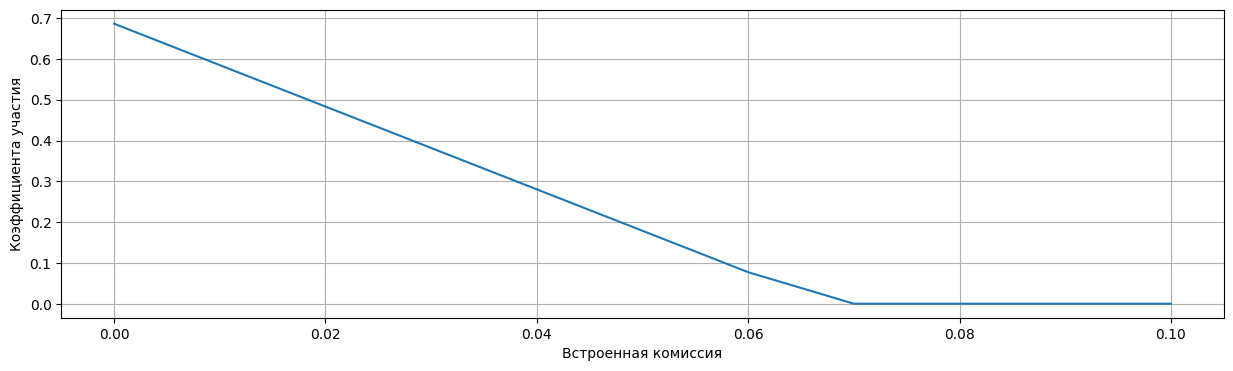

In [10]:
da = np.exp(-r * T) * N

Q = lambda fees: ( N * (1 - fees)  - da ) / c
fees = (np.linspace(0.0, 0.1, 11))
PR = K * Q(fees) / N

plt.figure(figsize=(15, 4))
#plt.title('PR from fees value')
plt.plot(fees, np.maximum(PR, 0))
plt.xlabel('Встроенная комиссия')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

Постройте график зависимости коэффициента участия от процентных ставок (депозитная и безрисковая ставки равны), проварьируйте ставки от 0 до 20% с шагом 1%.

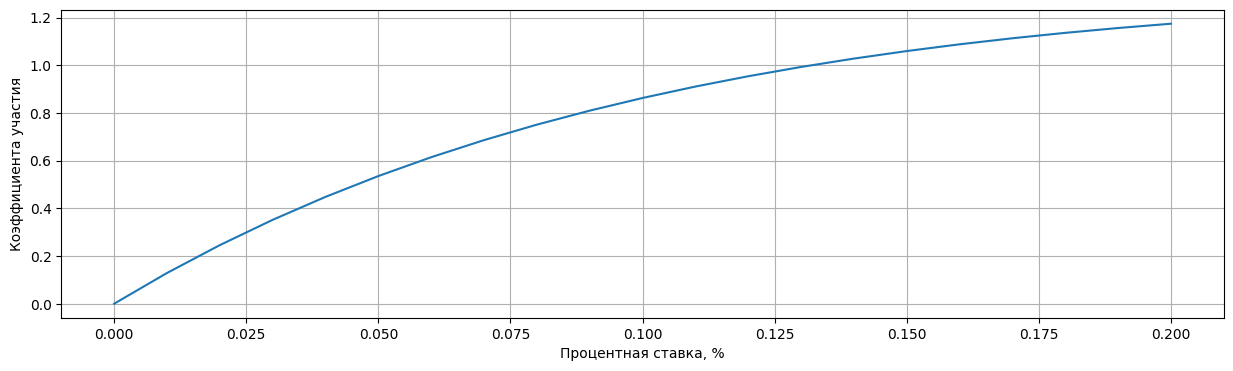

In [11]:
Q = lambda da, c: ( N * (1 - 0.0)  - da ) / c
rs = np.linspace(0, 0.2, 21)
cs = np.fromiter((call(S, K, T, sigma, ri, q) for ri in rs), dtype=np.float32)
das = np.exp(-rs * T) * N
Qs = np.fromiter((Q(da,c) for da,c in zip(das, cs)), dtype=np.float32)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from interest rate')
plt.plot(rs, np.maximum(PR, 0))
plt.xlabel('Процентная ставка, %')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

### Задача

Задача. Постройте трехмерных график зависимости коэффициента участия от депозитной и безрисковой ставок, проварьируйте ставки от 0 до 25% с шагом 1%.

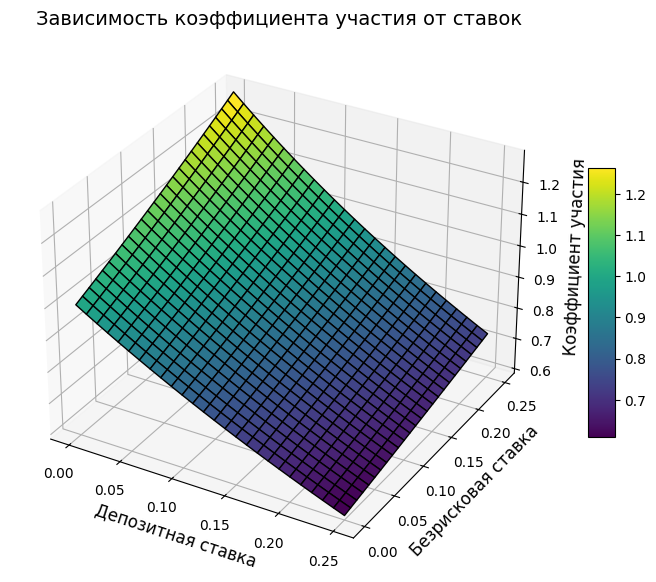

In [14]:
from mpl_toolkits.mplot3d import Axes3D

N = 1  
T = 1  
K = 1  
q = 0.0  

Q = lambda da, c: (N * (1 - 0.0) - da) / c


deposit_rates = np.linspace(0, 0.25, 26)  
risk_free_rates = np.linspace(0, 0.25, 26)  
deposit_rates_grid, risk_free_rates_grid = np.meshgrid(deposit_rates, risk_free_rates)


das = np.exp(-risk_free_rates_grid * T) * N 
cs = das + deposit_rates_grid  
participation_coefficient = Q(deposit_rates_grid, cs)  


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(deposit_rates_grid, risk_free_rates_grid, participation_coefficient,
                          cmap='viridis', edgecolor='k')

ax.set_title('Зависимость коэффициента участия от ставок', fontsize=14)
ax.set_xlabel('Депозитная ставка', fontsize=12)
ax.set_ylabel('Безрисковая ставка', fontsize=12)
ax.set_zlabel('Коэффициент участия', fontsize=12)

fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
plt.show()

Пример. Постройте график зависимости коэффициента участия от волатильности базового актива, проварьируйте волатильность от 0 до
100% с шагом 5%.

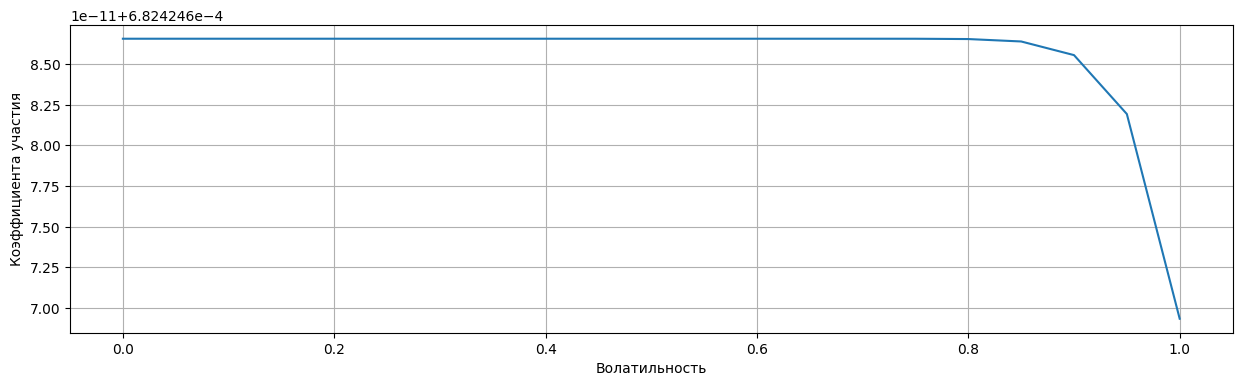

In [15]:
vs = np.linspace(1e-5, 1, 21)
cs = call(S, K, T, vs, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
Qs = Q(cs)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from volatility')
plt.plot(vs, PR)
plt.xlabel('Волатильность')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

Пример. Постройте график влияния срока продукта (от 0 до 100 лет, с
шагом 6 месяцев) на соотношение безрискового и рискового вложений.

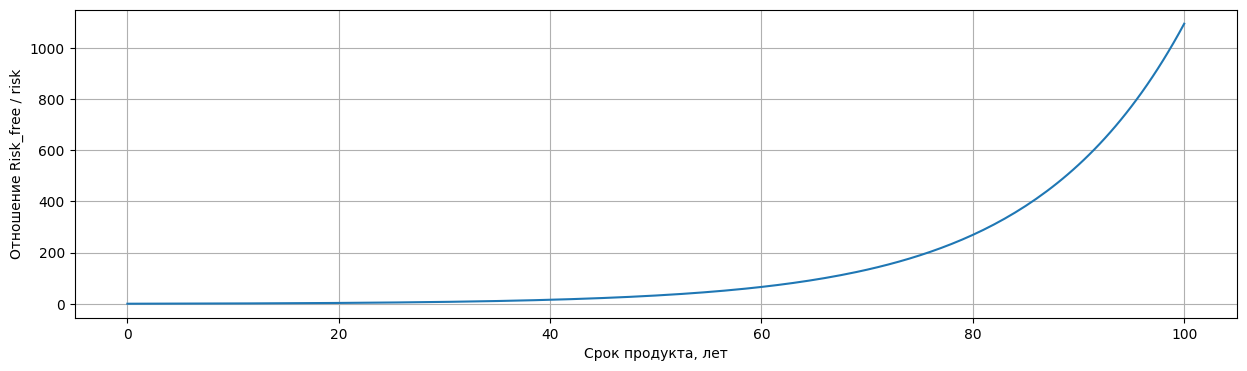

In [16]:
Ts = np.linspace(1e-5, 100, 201)
risk_parts = N - N * np.exp(-r * Ts)
ratios = risk_parts / (N - risk_parts)

plt.figure(figsize=(15, 4))
#plt.title('Risk-free to risk fraction relation on maturity date')
plt.plot(Ts, ratios)
plt.xlabel('Срок продукта, лет')
plt.ylabel('Отношение Risk_free / risk')
plt.grid()
plt.show()

Пример. Постройте график зависимости коэффициента участия от срока
продукта (от 0 до 20 лет, с шагом 6 месяцев).


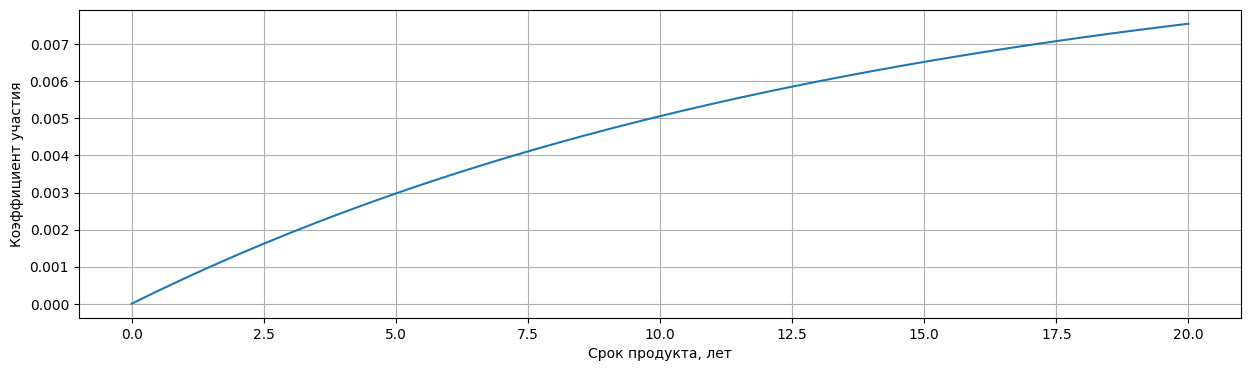

In [17]:
Ts = np.linspace(1e-5, 20, 41)
cs = call(S, K, Ts, sigma, r, q)
das = np.exp(-r * Ts) * N
Q = lambda c, d: ( N * (1 - 0.0)  - d ) / c
Qs = np.fromiter((Q(c, d) for c,d in zip(cs, das)), dtype=np.float64)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from maturity date')
plt.plot(Ts, PR)
plt.xlabel('Срок продукта, лет')
plt.ylabel('Коэффициент участия')
plt.grid()
plt.show()

Пример. Постройте график коэффициента участия от страйка продукта
(от 80 до 140, с шагом 10).

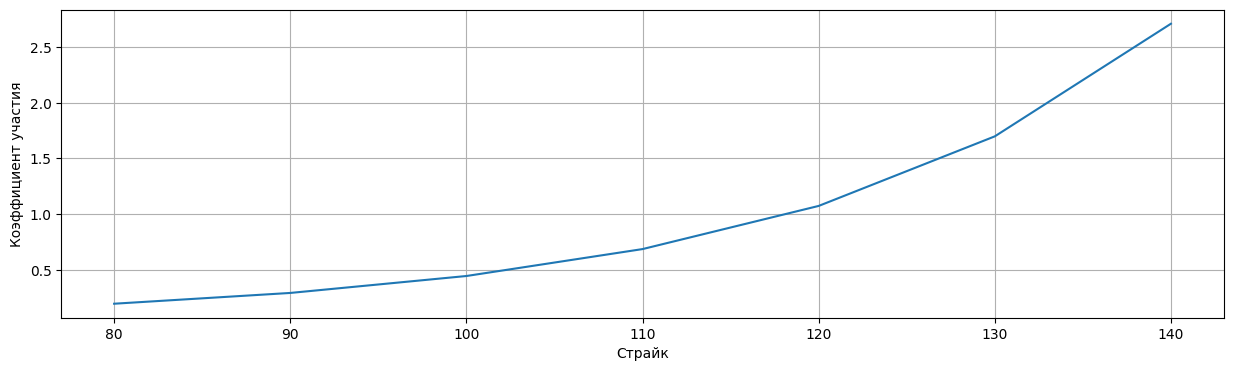

In [18]:
Ks = np.linspace(80, 140, 7)
cs = call(S, Ks, T,  sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
Qs = Q(cs)
PR = np.fromiter(((Kv * Qv / N) for Kv, Qv in zip(Ks, Qs)), dtype=np.float32)

plt.figure(figsize=(15, 4))
#plt.title('PR from strike')
plt.plot(Ks, PR)
plt.xlabel('Страйк')
plt.ylabel('Коэффициент участия')
plt.grid()
plt.show()

Пример. Постройте график доходности продуктов с разными страйками и
100% защитой капитала.

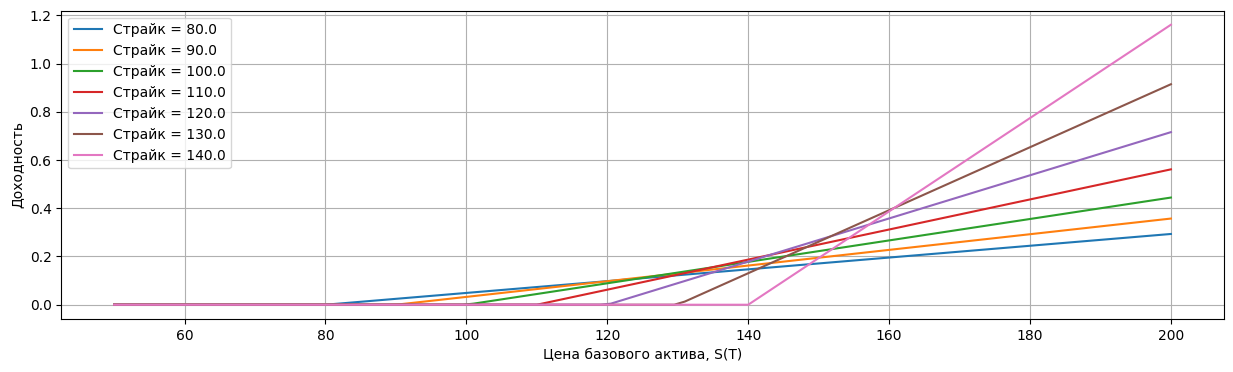

In [19]:
Ks = np.linspace(80, 140, 7)

cs = call(S, Ks, T, sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da) / c
Qs = Q(cs)
# Qs = np.fromiter((Q(c) for c in zip(cs, das)), dtype=np.float64)
PR = np.fromiter(((Kv * Qv / N) for Kv, Qv in zip(Ks, Qs)), dtype=np.float32)
Sm = np.linspace(0.5*S, 2*S, 101)

plt.figure(figsize=(15, 4))
#plt.title('Profit on UA')
for i, pr in enumerate(PR):
    rs = np.maximum(0, pr * (Sm - Ks[i]) / Ks[i])
    plt.plot(Sm, rs, label=f'Страйк = {Ks[i]}')
plt.xlabel('Цена базового актива, S(T)')
plt.ylabel('Доходность')
plt.legend()
plt.grid()
plt.show()

Пример. Постройте графики доходностей продуктов с одним страйком и
разной степенью защиты капитала (от 80% до 150%, с шагом 10%)

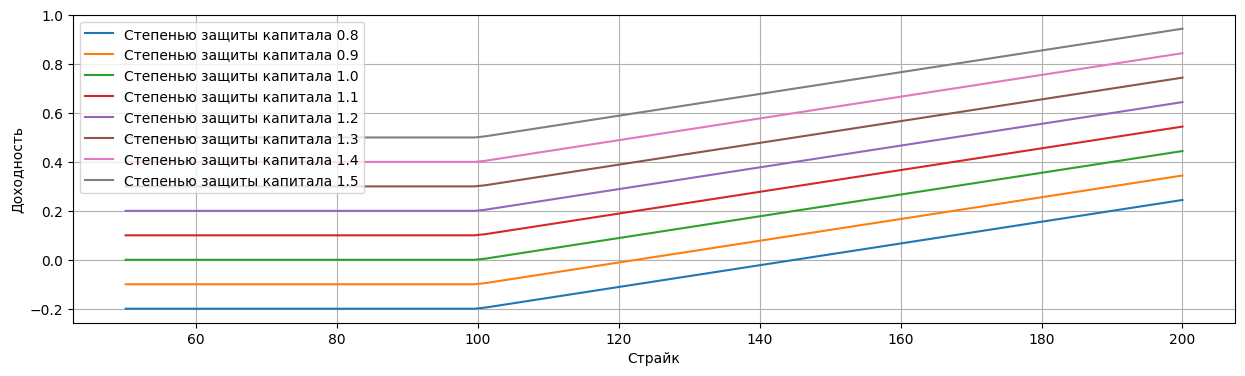

In [ ]:
gs = np.linspace(0.8, 1.5, 8)
c = call(S, K, T, sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
PR = K * Q(c) / N
Sm = np.linspace(0.5*S, 2*S, 101)

plt.figure(figsize=(15, 4))
#plt.title('PR from strike')
for i, g in enumerate(gs):
    returns = np.maximum(g - 1, (g - 1) + PR * (Sm - S)/S)
    plt.plot(Sm, returns, label=f'Степенью защиты капитала {g}')
plt.xlabel('Страйк')
plt.ylabel('Доходность')
plt.legend()
plt.grid()
plt.show()

### Задача

Задача. В условиях примера постройте 3D график зависимости доходности структурного продукта от

*   страйков и
*   степени защиты капитала.

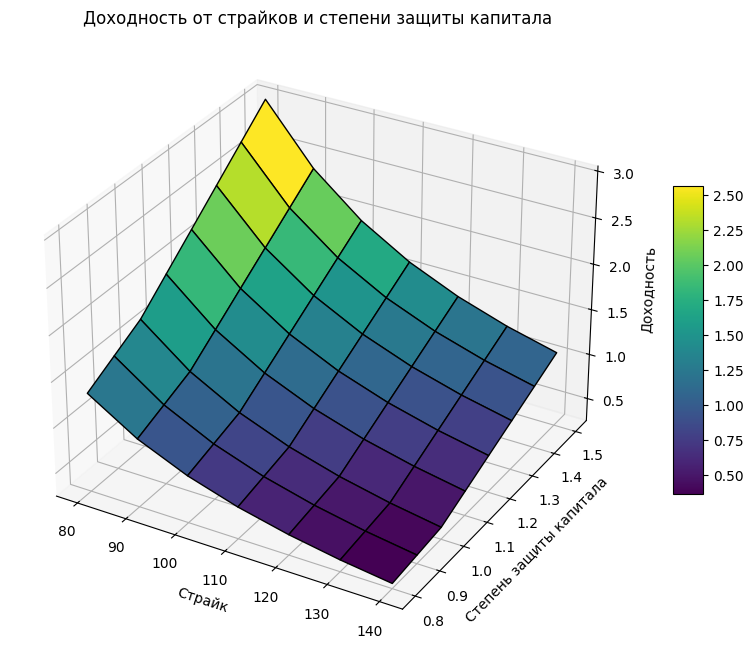

In [24]:
gs = np.linspace(0.8, 1.5, 8) 
Ks = np.linspace(80, 140, 7)  
Sm = np.linspace(0.5 * 140, 2 * 140, 101)  
T = 1  
sigma = 0.2  
r = 0.05  
q = 0.01  


returns = np.zeros((len(Ks), len(gs)))  

for i, g in enumerate(gs):
    for j, K in enumerate(Ks):
        c = Sm * np.exp(-r * T) * sigma 
        PR = g * c / K
        returns[j, i] = max(0, g - 1) + PR[-1] * (Sm[-1] - K) / K  


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
G, K = np.meshgrid(gs, Ks)
Z = returns
surf = ax.plot_surface(K, G, Z, cmap='viridis', edgecolor='k')

ax.set_title("Доходность от страйков и степени защиты капитала")
ax.set_xlabel("Страйк")
ax.set_ylabel("Степень защиты капитала")
ax.set_zlabel("Доходность")
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

Пример. В условиях примера для опциона колл повторите все расчеты с использованием бинарной стратегии, основанной на покупке и продаже европейского опциона пут.

Ширину диапазона доходности базового актива задать самостоятельно. Выбор обосновать.

In [25]:
S = 100
K = 100
T = 1
r = 0.07
q = 0
N = 100000
sigma = 0.3

K1 = 100
bo1 = binary_option_put('cash-or-nothing', S, K1, T, r, q, sigma)
K2=110
bo2 = binary_option_put('cash-or-nothing', S, K2, T, r, q, sigma)
print('digital range = ', -bo1+bo2)

risk_part = N - N*np.exp(-r*T)
Q = round(risk_part/(-bo1+bo2))
print('количество опционных стратегий', Q)

print('максимальная доходность, годовых = ', (N+Q)/(N*T)-1)
print('максимальная доходность, непрерывно = ', np.log((N+Q)/(N*T)))

digital range =  0.11734811871736428
количество опционных стратегий 57612
максимальная доходность, годовых =  0.57612
максимальная доходность, непрерывно =  0.45496613066900204


Пример. Постройте график функции выплат для бинарных стратегий, основанных
*   на покупке и продаже опционов колл,
*  на покупке и продаже опционов пут.



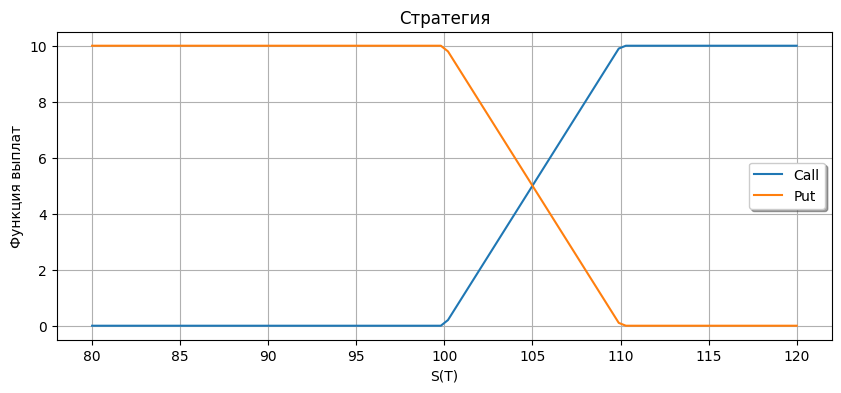

In [28]:
S = np.linspace(80, 120, 100)
C1 = np.maximum(S - K1, 0)
C2 = np.maximum(S - K2, 0)
P1 = np.maximum(-S + K1, 0)
P2 = np.maximum(-S + K2, 0)
plt.figure(figsize=(10,4))
plt.plot(S, C1 - C2, label=f'Call')
plt.plot(S, -P1 + P2, label=f'Put')
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel(f"S(T)")
plt.ylabel("Функция выплат")
plt.title("Стратегия")
plt.grid(True)
plt.show()

### Задача

Задача. Постройте графики трехмерных поверхностей для описания зависимости коэффициента участия при использовании бинарных опционов  
*   кол,
*   пут

от стоимости базового актива и количества дней до экспирации.

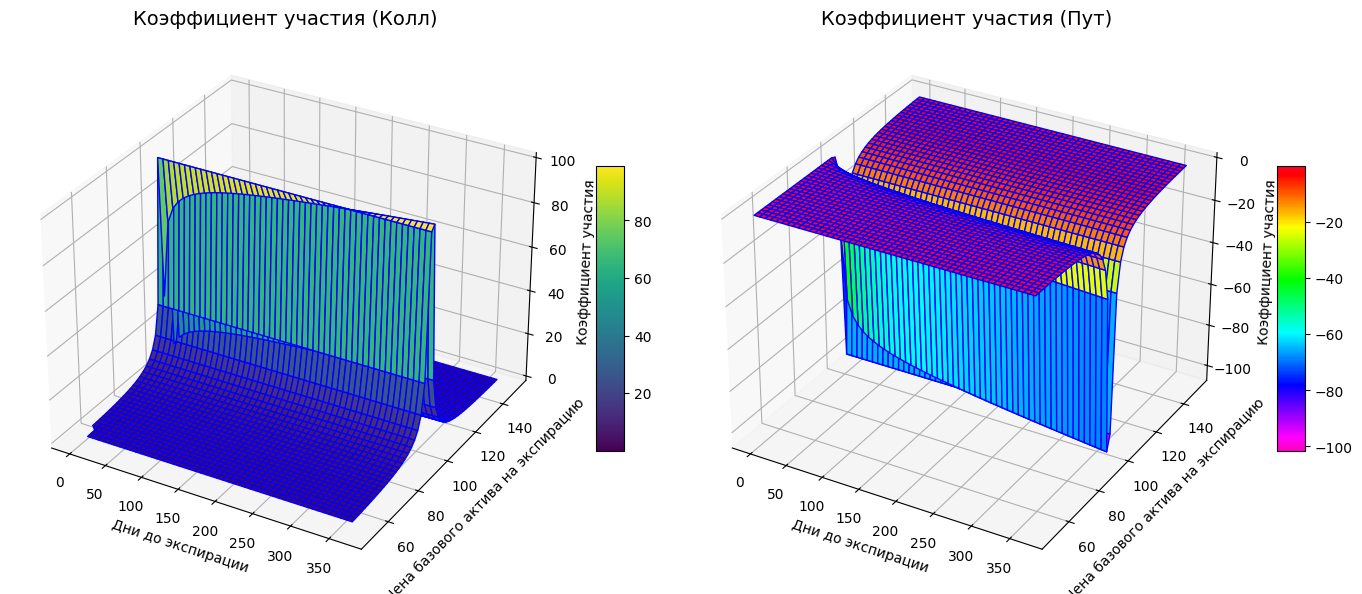

In [42]:
S_values = np.linspace(50, 150, 50)
T_values = np.linspace(1/365, 1, 50)
K = 100
r = 0.05
sigma = 0.3
N = 1000  
q = 0     

participation_call = np.zeros((len(S_values), len(T_values)))
participation_put = np.zeros((len(S_values), len(T_values)))

def binary_option_call(S, K, T, r, q, sigma):
    # Ценообразование бинарного опциона колл типа 'cash-or-nothing'
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return np.exp(-r * T) * norm.cdf(d2)

def binary_option_put(S, K, T, r, q, sigma):
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return np.exp(-r * T) * norm.cdf(-d2)


S0 = 100

for i, S_T in enumerate(S_values):
    for j, T in enumerate(T_values):
        call_price = binary_option_call(S_T, K, T, r, q, sigma)
        put_price = binary_option_put(S_T, K, T, r, q, sigma)

        call_payoff = 1 if S_T > K else 0
        put_payoff = 1 if S_T < K else 0

        call_return = (call_payoff - call_price) / call_price if call_price > 0 else np.nan
        put_return = (put_payoff - put_price) / put_price if put_price > 0 else np.nan
        asset_return = (S_T - S0) / S0 if S0 != 0 else np.nan


        participation_call[i, j] = call_return / asset_return if asset_return != 0 else np.nan
        participation_put[i, j] = put_return / asset_return if asset_return != 0 else np.nan


X, Y = np.meshgrid(T_values * 365, S_values) 
fig = plt.figure(figsize=(14, 6))


ax = fig.add_subplot(121, projection='3d')
surf_call = ax.plot_surface(X, Y, participation_call, cmap='viridis', edgecolor='b')
ax.set_title('Коэффициент участия (Колл)', fontsize=14)
ax.set_xlabel('Дни до экспирации', fontsize=10)
ax.set_ylabel('Цена базового актива на экспирацию', fontsize=10)
ax.set_zlabel('Коэффициент участия', fontsize=10)
fig.colorbar(surf_call, ax=ax, shrink=0.5, aspect=10)

ax = fig.add_subplot(122, projection='3d')
surf_put = ax.plot_surface(X, Y, participation_put, cmap='gist_rainbow_r', edgecolor='b')
ax.set_title('Коэффициент участия (Пут)', fontsize=14)
ax.set_xlabel('Дни до экспирации', fontsize=10)
ax.set_ylabel('Цена базового актива на экспирацию', fontsize=10)
ax.set_zlabel('Коэффициент участия', fontsize=10)
fig.colorbar(surf_put, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

## CП с использованием гэп опционов

### Задача

Задача. Рассмотрим гэп опционы колл и пут на недивидендные акции со страйком 57 и сроком действия, истекающим 1 июля следующего года, на 1 января текущего года акции торгуются по цене 50.

Используя эти данные, вычислите цену опциона колл и пут, если безрисковая ставка равна 9%, цена страйк 50, волатильность 20%.

In [44]:
import math
S0 = 50      
K1 = 57      
K2 = 50      
r = 0.09     
q = 0       
sigma = 0.2  
T = 1.5      

d1 = (math.log(S0 / K2) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
d2 = d1 - sigma * math.sqrt(T)

Nd1 = norm.cdf(d1)
Nd2 = norm.cdf(d2)
N_minus_d1 = norm.cdf(-d1)
N_minus_d2 = norm.cdf(-d2)

C_gap = S0 * math.exp(-q * T) * Nd1 - K1 * math.exp(-r * T) * Nd2
P_gap = K1 * math.exp(-r * T) * N_minus_d2 - S0 * math.exp(-q * T) * N_minus_d1

print(f"Gap Call Option Price: {C_gap:.4f}")
print(f"Gap Put Option Price: {P_gap:.4f}")

Gap Call Option Price: 4.3222
Gap Put Option Price: 4.1241


В рамках модели Блэка-Шоулза решите следующие задачи для бинарных опционов.

Пример. Маркет-мейкер продает европейские гэп-колл опционы сумму 1000 сроком на один год и дельта-хеджирует позицию акциями.
Опцион гэп-колл выписан на одну акцию, не приносящую дивидендов. Текущая цена акции составляет 100.

Волатильность акции составляет 100\%. Каждый колл-гэп опцион  имеет цену исполнения 130, триггер цена равна  100. Безрисковая процентная ставка равна 0\%.

В рамках модели Блэка-Шоулза определите начальное количество акций для  дельта-хеджирования.

**Указание.** Определите дельту опциона и умножьте на 1000.

In [45]:
def first_derivative (f , x , args, h = 0.0001) :
    return (f(x + h, *args) - f(x - h, *args)) / (2 * h)

In [47]:
def gap_option(S, K1, K2, T, r, sigma, q, type_option):
    # Calculate d1 and d2
    d1 = (math.log(S / K2) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if type_option == 'call':
        price = S * math.exp(-q * T) * norm.cdf(d1) - K1 * math.exp(-r * T) * norm.cdf(d2)
    elif type_option == 'put':
        price = K1 * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)
    else:
        print("Incorrect type option")
        return None
    return price

In [50]:
S = 100
K1 = 130 # strike
K2 = 100 # trigger
r = 0.0
sigma = 1
T = 1
q = 0

c = gap_option(S, K1, K2, T, r, sigma, q, type_option='call')
delta = first_derivative(lambda S, *args: gap_option(S, *args, type_option='call'), S, (K1, K2, T, r, sigma, q))
print(c, round(delta * 1000))

29.03636609302302 586


### Задача

Задача. В условиях примера определите начальное количество акций для дельта-хеджирования с использованием пут-гэп опционов. Выбор цены исполнения и триггер цены обосновать.

In [65]:
import numpy as np
from scipy.stats import norm

S = 100
K1 = 130 
K2 = 130 
r = 0.0
sigma = 1
T = 1
q = 0 

c = gap_option(S, K1, K2, T, r, sigma, q, type_option='put')
delta = first_derivative(lambda S, *args: gap_option(S, *args, type_option='put'), S, (K1, K2, T, r, sigma, q))
print(c, round(abs(delta)*1000), delta)

60.412047592704106 406 -0.40608181574697255



Обоснование значительного "вне денег" положения

- При \( S = 100 \) и \( K_1 = K_2 = 130 \), **опцион находится "вне денег"** (\( S < K_2 \)).
- Это делает его стоимость **относительно низкой**, поскольку вероятность исполнения опциона мала.
- Такой выбор оправдан, если целью является:
  - **Дешёвое хеджирование крупных рисков**, или
  - **Спекулятивная игра** на сильное изменение цен базового актива.

Пример. Безрисковая процентная ставка составляет 6%, волатильность бездивидендных акций составляет 32%. Четырехлетний опцион пут «деньги или ничего» на эту акцию с триггерной ценой 135 имеет премию 0,32494. Найдите цену 4-летнего опциона колл «актив или ничего» на эту акцию с триггерной ценой 135.

In [ ]:
r = 0.06
sigma = 0.32
T = 4
K = 135
q = 0
put = 0.32494
put_type = 'cash-or-nothing'

opt_func = lambda x: binary_option_put(put_type, x, K, T, r, q, sigma) - put
S = fsolve(opt_func, K)[0]

call_type = 'asset-or-nothing'
call = binary_option_call(call_type, S, K, T, r, q, sigma)
call

120.75083564309931

Пример. Волатильность базового актива 25%, волатильность годового опциона колл со страйком 50 на акции составляет 120,68%. Маркет-мейкер выписывает один опцион колл и дельта хеджирует свою позицию. Стоимость акции в хеджирующем портфеле равна 34,74. Найдите цену годового опциона «деньги или ничего» колл на акцию с триггерной ценой 50.

In [ ]:
r = 0.00
sigma_S = 0.25
sigma_call = 1.2068
K = 50
T = 1
K2 = 50
S_hedge = 34.74
q = 0
call_type = 'cash-or-nothing'
call = binary_option_call(call_type, S_hedge, K, T, r, q, sigma_S)
call

0.05687902614969493

### Задача

Задача. На акции по текущей цене 75 выплачивают дивиденды по ставке 2% (непрырывное начисление), волатильность акций 40%. Коэффициент Шарпа для акции равен 0. Шестимесячный опцион «актив или ничего» колл на акцию с триггером 80 стоит 36,65.

Рассчитайте вероятность того, что опцион колл «актив или ничего» будет исполнен.

В условиях примера проанализируйте зависимость вероятности исполнения опциона колл «актив или ничего» от коэффициента Шарпа.

Приведите иллюстративные графики.

Для Sharpe Ratio = 0:
Вероятность исполнения стандартного call-опциона: 0.3825
Вероятность исполнения опциона «актив или ничего»: 0.2804


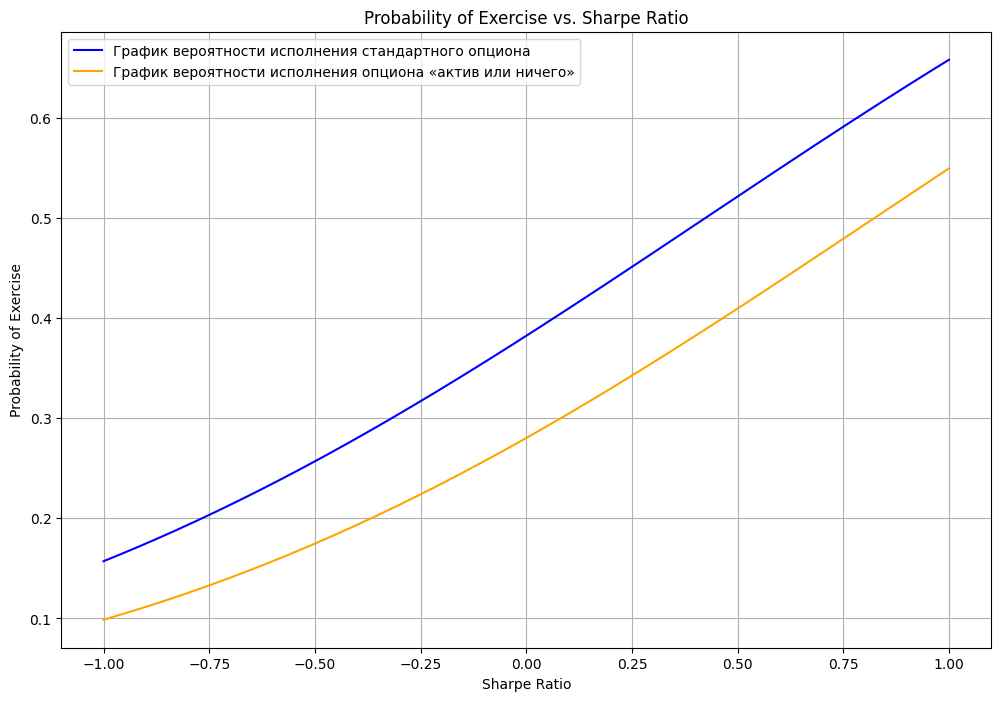

In [71]:
S0 = 75     
K = 80       
sigma = 0.4  
T = 0.5      
q = 0.02     
C = 36.65    

def option_price_diff(r):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    N_d1 = norm.cdf(d1)
    C_calc = S0 * np.exp(-q * T) * N_d1
    return C_calc - C

r_solution = brentq(option_price_diff, 0.0, 0.2)


Sharpe_ratios = np.linspace(-1, 1, 200)
probabilities = []
asset_or_nothing_probs = []

for Sharpe in Sharpe_ratios:
    mu = r_solution + Sharpe * sigma
    drift = (mu - q - 0.5 * sigma ** 2) * T
    d1 = (drift + np.log(S0 / K)) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    prob = norm.cdf(d1)
    probabilities.append(prob)
    
    asset_or_nothing_prob = norm.cdf(d2)
    asset_or_nothing_probs.append(asset_or_nothing_prob)



target_sharpe = 0
mu = r_solution + target_sharpe * sigma

drift = (mu - q - 0.5 * sigma ** 2) * T
d1 = (drift + np.log(S0 / K)) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)


prob_standard_call = norm.cdf(d1)  
prob_asset_or_nothing = norm.cdf(d2)  


print(f"Для Sharpe Ratio = {target_sharpe}:")
print(f"Вероятность исполнения стандартного call-опциона: {prob_standard_call:.4f}")
print(f"Вероятность исполнения опциона «актив или ничего»: {prob_asset_or_nothing:.4f}")


plt.figure(figsize=(12, 8))
plt.plot(Sharpe_ratios, probabilities, label='График вероятности исполнения стандартного опциона', color='blue')
plt.plot(Sharpe_ratios, asset_or_nothing_probs, label='График вероятности исполнения опциона «актив или ничего»', color='orange')
plt.title('Probability of Exercise vs. Sharpe Ratio')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Probability of Exercise')
plt.grid(True)
plt.legend()
plt.show()